In [9]:
import RNA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import SVG, display
import seaborn as sns

from collections import Counter
from collections import defaultdict
import subprocess
import difflib
import sys
import os
import random
import string
import time

import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

sys.path.append('../')
from pretty_print_path import print_moves
import findpath_librna
import findpath

import helper


In [10]:
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True) # no scientific notation

# import feature_generation
from features import ij_distance, new_move_dist, plt_moves, config_distance, balance_in_all_things, return_shift_moves
from process_features import fp_call, find_moves, process

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def adjust_pt(pt, i, j):
    pt_adj = pt.copy()
    if i<0:
        pt_adj[-i] = 0
        pt_adj[-j] = 0
    else:
        pt_adj[i] = j
        pt_adj[j] = i
    return pt_adj

def next_vicinity(lastmove, avail_moves):

    """
    percentage of moves which can continue in the vicinity of the last move
    """
    lasti, lastj = lastmove
    moves = len(avail_moves)
    cntr = 0

    for a in avail_moves:
        i=a[0]
        j=a[1]      
        if lasti + 1 == i or lasti - 1 == i or\
           lastj + 1 == j or lastj - 1 == j:
           cntr += 1
    return cntr

def last_vs_best(lastmove, bestmove, lensequence):
    lasti = abs(lastmove[0])
    lastj = abs(lastmove[1])
    i = abs(bestmove[0])
    j = abs(bestmove[1])
    dist = abs(lasti - i) + abs(lastj - j)
    return dist/(lensequence*2) #, dist, lensequence


def cluster_moves(inputmoves, absolute_values=False):
    """
    cluster moves with DBscan. needs to include the last move as well...
    """

    if absolute_values:
        m = [(abs(i[0]), abs(i[1])) for i in inputmoves]
        moves = np.array(m)
    else:
        m = [(i[0], i[1]) for i in inputmoves]
        moves = np.array(m)

    # print ("clustering", moves)
    clustering = DBSCAN(eps=2, min_samples=1).fit(moves)
    
    # generate clustering dict (move-tuple:label, ...)
    return {i[0]:i[1] for i in zip(m, clustering.labels_)}, clustering.labels_



def structure_evaluation(fc, pt1, pt2, path, lastmove):
    avail_moves = []
    fp_results = []
    en_contrib = []

    available_add = set()
    available_delete = set()
    lensequence = pt1[0]

    # pt1 = list(RNA.ptable(s))
    # pt2 = list(RNA.ptable(s2))
    for pos, (i,j) in enumerate(find_moves(pt1, pt2)):    
        next_en = fc.eval_move_pt(pt1, i, j)
        # mark where we found our move    
        # map energies somehow to [0,1] such that the network will understand.  
        en = np.interp(next_en/100, [-10,10], [0,1]) 
        en_contrib.append(en)
        avail_moves.append((i, j, next_en))

        if i>0:
            available_add.add((i,j))
        elif i<0:
            available_delete.add((i,j))

    if len(avail_moves)==0:
        add_delete = 0
    else:
        add_delete = len(available_delete)/len(avail_moves)

    # print ('best', en_contrib[0], 'avg', en_mean)

    avail_moves.sort(key=lambda x: x[2]) # best move at [0]


    vic = next_vicinity(lastmove, avail_moves)
    vic_best = next_vicinity(lastmove, avail_moves[0:1])

    avail_moves = [(i[0], i[1]) for i in avail_moves]
    avail_moves_abs = [(abs(i[0]), abs(i[1])) for i in avail_moves] # this is sorted as well, best move at [0]

    # absolute_moves+=[lastmove]
    # print ("avail+last", avail_moves)

    # last_index = -1
    # best_index = absolute_moves.index((abs(absolute_moves[0][0]), abs(absolute_moves[0][1])))
    # print ("best", best_index)

    p = [(0, 0)] + [(i[0], i[1]) for i in path]
    clustered_moves, _ = cluster_moves(p, absolute_values=False)
    clustered_moves_abs, _ = cluster_moves(p, absolute_values=True)

    bestmove = avail_moves[0]
    bestmove_abs = avail_moves_abs[0]

    lastmove_abs = abs(lastmove[0]), abs(lastmove[1])

    # last move vicinity is available, but not among the best energy options:

    unique_found = set()
    foundpos = -1
    for pos, m in enumerate(avail_moves):
        l = clustered_moves[m]
        if l == clustered_moves[lastmove]:
            foundpos = len(unique_found) # cant add pos here

        if l not in unique_found:
            unique_found.add(l)
    if foundpos == -1:
        foundpos = len(unique_found)
    foundpos /= len(unique_found)

    unique_found_abs = set()
    foundpos_abs = -1
    for pos, m in enumerate(avail_moves_abs):
        l = clustered_moves_abs[m]
        if l == clustered_moves_abs[lastmove_abs]:
            foundpos_abs = len(unique_found_abs) # cant add pos here

        if l not in unique_found_abs:
            unique_found_abs.add(l)
    if foundpos_abs == -1:
        foundpos_abs = len(unique_found_abs)
    foundpos_abs /= len(unique_found_abs)

    # print (foundpos, last_is_best, last_is_best_abs)
    # print ("bestmove", bestmove, clustered_moves[bestmove], bestmove_abs, clustered_moves_abs[bestmove_abs])
    # print ("lastmove", lastmove, clustered_moves[lastmove], lastmove_abs, clustered_moves_abs[lastmove_abs])

    # distlast = last_vs_best(clustered_moves)

    unique_labels = 1 / len(unique_found)
    # unique_moves = 1/unique_labels

    distlast = last_vs_best(lastmove, bestmove, lensequence)
    unique_moves = 0

    # print ("unique", unique_labels, unique_moves)

    count_available = len(avail_moves)/len(path)


    for pos, (i,j) in enumerate(avail_moves):  
        pt = adjust_pt(pt1, i, j)
        snew = RNA.db_from_ptable(pt)
        # if i > 0:
        #     snew = s[:i-1] + "(" + s[i:j-1] + ")" + s[j:]
        # if i < 0:
        #     snew = s[:-i-1] + "." + s[-i:-j-1] + "." + s[-j:]

        ptnew = list(RNA.ptable(snew))
        result_new, path = fp_call(sequence, snew, s2, search_width_multiplier)
        fp_results.append(result_new)

    if len(avail_moves) == 0:
        label = 0
        en_mean = 0
        en_std = 0
        best_en = 0

    else:
        label = np.argmin(fp_results)/len(fp_results)

        en_mean = np.mean(en_contrib)
        en_std = np.std(en_contrib)
        en_contrib.sort(key=lambda x: x)
        en_diff = en_contrib[0] / en_mean # best en, relative

        best_en = en_contrib[0]

   
    return label, en_mean, en_std, best_en, foundpos, foundpos_abs, distlast, unique_labels

In [4]:
# alternative 192
# 807 ! 809 13   417

sw = 4

filename_samples = f'./dataset_100_large.csv'
# filename_samples = f'./dataset_200_large.csv'

samples_df = pd.read_csv(filename_samples)
for index, row in samples_df.iterrows():
    if index != 423:
        continue
    sequence = row.sequence
    s1 = row.s1
    s2 = row.s2


print(f"sequence = \"{sequence}\"")
print(f"s1 = \"{s1}\"")
print(f"s2 = \"{s2}\"")
print (RNA.bp_distance(s1, s2))


fp = findpath.findpath_single(sequence, s1, s2, search_width_multiplier=sw, mp=True)
result = fp.get_en()/100.0
path = fp.get_path()
print_moves(sequence, s1, s2, path, convert_to_float=True)

# helper.plot_layout(sequence, s2)

sequence = "AGCAAUUGUUGUCGCGGAUGAAUAAGUUGAUUAAAUAACGUGAUGAUCCUAUAAGUCGUUGCACAUAGACUCCGCAUCGCGAUUAGCAGAAACUAUGGUC"
s1 = ".((((((((.((.(((((.......((((......))))((((((((.......))))))))........))))))).)))))).))............."
s2 = "......((((((((((.(((....((((.......(((((..(((....)))....)))))......))))...)))))))).)))))............"
52
AGCAAUUGUUGUCGCGGAUGAAUAAGUUGAUUAAAUAACGUGAUGAUCCUAUAAGUCGUUGCACAUAGACUCCGCAUCGCGAUUAGCAGAAACUAUGGUC
[   0,    0 ] .((((((((.((.(((((.......((((......))))((((((((.......))))))))........))))))).)))))).)).............  -19.10
[ -11,  -77 ] .((((((((..(.(((((.......((((......))))((((((((.......))))))))........))))))..)))))).)).............  -17.10
[ -12,  -76 ] .((((((((....(((((.......((((......))))((((((((.......))))))))........)))))...)))))).)).............  -17.90
[  -4,  -84 ] .((.(((((....(((((.......((((......))))((((((((.......))))))))........)))))...)))))..)).............  -15.70
[  -5,  -83 ] .((..((((....(((((.......((((......))))((((((((.......))))))

-7.4

In [5]:

s1 = ".((((((((.((.(((((.......((((......))))((((((((.......))))))))........))))))).)))))).))............."
s2 = "......((((((((((.......................((((((((.......))))))))...............))))).)))))............"
# helper.plot_layout(sequence, s1)

# s1, s2 = s2, s1

fp = findpath.findpath_single(sequence, s1, s2, search_width_multiplier=sw, mp=True)
result = fp.get_en()/100.0
path = fp.get_path()
print_moves(sequence, s1, s2, path, convert_to_float=True)

AGCAAUUGUUGUCGCGGAUGAAUAAGUUGAUUAAAUAACGUGAUGAUCCUAUAAGUCGUUGCACAUAGACUCCGCAUCGCGAUUAGCAGAAACUAUGGUC
[   0,    0 ] .((((((((.((.(((((.......((((......))))((((((((.......))))))))........))))))).)))))).)).............  -19.10
[  -2,  -87 ] ..(((((((.((.(((((.......((((......))))((((((((.......))))))))........))))))).)))))).)..............  -15.30
[  -3,  -86 ] ...((((((.((.(((((.......((((......))))((((((((.......))))))))........))))))).))))))................  -16.20
[ -11,  -77 ] ...((((((..(.(((((.......((((......))))((((((((.......))))))))........))))))..))))))................  -14.20
[ -12,  -76 ] ...((((((....(((((.......((((......))))((((((((.......))))))))........)))))...))))))................  -15.00
[  -9,  -79 ] ...(((((.....(((((.......((((......))))((((((((.......))))))))........)))))....)))))................  -12.90
[  -4,  -84 ] ....((((.....(((((.......((((......))))((((((((.......))))))))........)))))....)))).................  -11.90
[  -5,  -83 ] .....(((.....(((((......

-7.4

In [334]:

if True:

    # sequence = row.sequence
    # s1 = row.s1
    # s2 = row.s2

    bp_dist = RNA.bp_distance(s1, s2)
    fc = RNA.fold_compound(sequence)
    pt1 = list(RNA.ptable(s1))
    pt2 = list(RNA.ptable(s2))


    fp = findpath.findpath_single(sequence, s1, s2, search_width_multiplier=sw, mp=False)
    sE = fp.get_en()/100.0
    path = fp.get_path()

 

    p = [(0, 0)] + [(i[0], i[1]) for i in path]

    p.sort(key=lambda x: (x[0], x[1]))


    clustered_moves, clabels = cluster_moves(p, absolute_values=False)
    clustered_moves_abs, clabels_abs = cluster_moves(p, absolute_values=True)

    print (path)
    print (clustered_moves)
    print (clabels)


    for e, (i,j, cen) in enumerate(path):
        # move on along the predefined path

        if e+1==len(path):
            break

        if e!=0:
            # print ("adj1", RNA.db_from_ptable(ptlast), lastmove[0], lastmove[1])
            pt = adjust_pt(ptlast, i, j)
            # print ("adj2", RNA.db_from_ptable(pt))
        else:
            lastmove = 0,0
            pt = pt1.copy()

        nextmove = path[e+1][0], path[e+1][1]
        # print ("iteration", e, i, j, nextmove)
        # print ("s  :", RNA.db_from_ptable(pt), lastmove[0], lastmove[1])

        lastmove = i, j
        ptlast = pt.copy()

        avail_moves = []
        fp_results = []
        en_contrib = []
        avail_clusters = defaultdict(list)
        avail_dict = dict()
        available_add = set()
        available_delete = set()
        lensequence = pt1[0]

        for pos, (i,j) in enumerate(find_moves(pt, pt2)):    
            next_en = fc.eval_move_pt(pt, i, j)
            # mark where we found our move    
            # map energies somehow to [0,1] such that the network will understand.  
            en = np.interp(next_en/100, [-10,10], [0,1]) 
            en_contrib.append(en)
            avail_moves.append((i, j, next_en))
            avail_dict[(i,j)] = next_en

            if i>0:
                available_add.add((i,j))
            elif i<0:
                available_delete.add((i,j))

            current_label = clustered_moves[(i,j)]
            # current_label = clabels[pos]
            avail_clusters[current_label].append((i,j))

            # print ("iteration!", e, pos, i, j, current_label)

        if len(avail_moves)==0:
            add_delete = 0
        else:
            add_delete = len(available_delete)/len(avail_moves)

        # print ('best', en_contrib[0], 'avg', en_mean)

        avail_moves.sort(key=lambda x: x[2]) # best move at [0]

        # print (sE)
        # print (clustered_moves)
        # print (clabels)
        # print ("avail", avail_dict)
        count_available = len(avail_moves)/len(path)
        # print (e, len(avail_dict), avail_clusters)

        for (i, j, nexten) in avail_moves:

            if (i,j) in avail_dict:
                # print (e, i, j,)
                if (i,j)!=nextmove:continue
                # current_label = clabels[pos]
                current_label = clustered_moves[(i,j)]
                # nexten = avail_dict[(i,j)]

                ptnew = adjust_pt(pt, i, j)
                snew = RNA.db_from_ptable(ptnew)
                # print ("snew", snew)
                # result_new, _ = fp_call(sequence, snew, s2, sw)
                result_new = "/"
                fp_results.append(result_new)

                members = avail_clusters[current_label]

                #if e==8: 
                # ppos = p.index((i,j))
                # print (i, j, members)
                clusterpos = members.index((i,j))
                clusterpos2 = members.index((i,j))
                if len(members)-1 != 0:
                    clusterpos2 /= (len(members)-1)

                adj_clusterpos = abs(abs(clusterpos2-0.5)-0.5)*2


                member_en = np.array([avail_dict[i] for i in members])
                # Normalised [0,1] https://stackoverflow.com/questions/1735025/how-to-normalize-a-numpy-array-to-within-a-certain-range
                if len(member_en)==1:
                    member_en_normalized = [0]
                else:
                    member_en_normalized = (member_en - np.min(member_en))/np.ptp(member_en)
                # member_en_normalized = member_en

                # print ("iter", e, nextmove, (i,j)==nextmove, (i,j), nexten, result_new, current_label, members, clusterpos)


                print ("iter", e, nextmove, (i,j)==nextmove, (i,j), nexten, result_new, adj_clusterpos, member_en_normalized[clusterpos], members, member_en) # adj_clusterpos, "members", 

                # avail_clusters[current_label].append(e)

        

        # if e==1:
        #     break

    # for pos, (i,j, nexten) in enumerate(avail_moves):  
    #     pt = adjust_pt(pt1, i, j)
    #     snew = RNA.db_from_ptable(pt)

    #     ptnew = list(RNA.ptable(snew))
    #     result_new, path = fp_call(sequence, snew, s2, search_width_multiplier)
    #     fp_results.append(result_new)
    #     print (i,j,nexten, result_new)
    #     clusterid = clustered_moves[(i,j)]
    #     clustermembers = np.where(clabels==clusterid)[0]
    #     for i in clustermembers:
    #         print ("member", i, p[i])



[(0, 0, -1610), (-33, -55, -1160), (-32, -56, -1200), (-31, -58, -750), (-30, -59, -980), (-27, -61, -750), (-34, -54, -600), (-26, -62, -820), (-35, -53, -927), (27, 37, -520), (28, 36, -660), (29, 35, -840), (-42, -46, -760), (-41, -47, -620), (26, 38, -710), (-40, -48, -530), (-39, -49, -890), (45, 56, -560), (46, 55, -870), (-22, -65, -760), (44, 57, -870), (-4, -18, -690), (43, 58, -1000), (-20, -67, -670), (-5, -17, -670), (-21, -66, -1120), (-6, -16, -740), (-7, -15, -1080), (13, 63, -630), (14, 62, -750), (12, 64, -890), (11, 65, -1040), (10, 66, -1270), (42, 59, -1280), (6, 69, -1100), (7, 68, -1460), (5, 70, -1530), (23, 41, -1380), (24, 40, -1470)]
{(-42, -46): 0, (-41, -47): 0, (-40, -48): 0, (-39, -49): 0, (-35, -53): 1, (-34, -54): 1, (-33, -55): 1, (-32, -56): 1, (-31, -58): 2, (-30, -59): 2, (-27, -61): 3, (-26, -62): 3, (-22, -65): 4, (-21, -66): 4, (-20, -67): 4, (-7, -15): 5, (-6, -16): 5, (-5, -17): 5, (-4, -18): 5, (0, 0): 6, (5, 70): 7, (6, 69): 7, (7, 68): 7, (10

<ipython-input-334-7a2764687e09>:132: RuntimeWarning: invalid value encountered in true_divide
  member_en_normalized = (member_en - np.min(member_en))/np.ptp(member_en)


In [7]:

## todo: drop second best true label after we found the first one 

filename_samples = f'./dataset_100_large.csv'
samples_df = pd.read_csv(filename_samples)

search_width_multiplier = 4
df = pd.DataFrame()
all_results = []



for index, row in samples_df.iterrows():
    # if index != 90:
    #     continue

    
    sequence = row.sequence
    s1 = row.s1
    s2 = row.s2

    bp_dist = RNA.bp_distance(s1, s2)
    fc = RNA.fold_compound(sequence)
    pt1 = list(RNA.ptable(s1))
    pt2 = list(RNA.ptable(s2))

    print (bp_dist)
    
    fp = findpath.findpath_single(sequence, s1, s2, search_width_multiplier=search_width_multiplier, mp=False)
    sE = fp.get_en()/100.0
    path = fp.get_path()

    p = [(0, 0)] + [(i[0], i[1]) for i in path]
    clustered_moves, _ = cluster_moves(p, absolute_values=False)
    clustered_moves_abs, _ = cluster_moves(p, absolute_values=True)

    # print (clustered_moves)

    random_moves = random.choices([i[0] for i in path], k=3)

    ptlast = list(RNA.ptable(s1))
    pt = list(RNA.ptable(s1))

    prev_move_dist = np.zeros((20))  
    lastmove = 0, 0
    all_evals = 0
    results = []

    # find a random structure in the path
    # ignore the last moves, we're not interested in meaningless decisions
    for i, j, en in path:
        
        print (i,j)
        
        if i==0: 
            continue

        prev_move_dist = new_move_dist(abs(lastmove[0]), abs(lastmove[1]), prev_move_dist)
        

        # if i in random_moves:
        if True:
            label, _, _, _, _, _, _, _ = structure_evaluation(fc, pt, pt2, path, lastmove)
                    
            # we take this current intermediate structure and see if we can predict which moves may be the best ones
            # pretend we dont know i and j - substitute with a and b

            avail_moves = []
            ij_moves = []
            found_pos = None
            sElist = []
            balancelist = []

            for pos, (a,b) in enumerate(find_moves(pt, pt2)):    

                ptnew = pt.copy()
                ptnew = adjust_pt(ptnew, a, b)
                s = RNA.db_from_ptable(ptnew)

                fp = findpath.findpath_single(sequence, s, s2, search_width_multiplier=search_width_multiplier, mp=False)
                sE = fp.get_en()/100.0
                sElist.append(sE)


                next_en = fc.eval_move_pt(pt, a, b)
                avail_moves.append((a, b, next_en))

            avail_moves.sort(key=lambda x: x[2])
            en_list = np.array([[x[2] for x in avail_moves]])
            en_list_scaled = min_max_scaler.fit_transform(en_list.T).T[0]

            # print (index, i, label, lastmove)
            # print (RNA.db_from_ptable(pt), prev_move_dist, i, j)
            # print (avail_moves)

            i_values = []
            j_values = []

            for pos, (a, b, en) in enumerate(avail_moves):
            
                ptnew = pt.copy()
                ptnew = adjust_pt(ptnew, a, b)
                s = RNA.db_from_ptable(ptnew)

                fp = findpath.findpath_single(sequence, s, s2, search_width_multiplier=search_width_multiplier, mp=False)
                sE = fp.get_en()/100.0
                sElist.append(sE)

                # i_bar = int(round(abs(a) / 5.0))
                # j_bar = int(round(abs(b) / 5.0))
                i_bar = int(abs(a) / 5.001)
                j_bar = int(abs(b) / 5.001)

                # path = fp.get_path()
                i_value = round(prev_move_dist[i_bar], 4)
                j_value = round(prev_move_dist[j_bar], 4)
                i_values.append(i_value)
                j_values.append(j_value)

                balancelist.append(balance_in_all_things(s1, s2, s) / len(path))
                                

            sElist = min_max_scaler.fit_transform(np.array([sElist]).T).T[0]
            balancelist = min_max_scaler.fit_transform(np.array([balancelist]).T).T[0]

            for (a,b, _), en, sEscaled, i_value, j_value, balance in zip(avail_moves, en_list_scaled, sElist, i_values, j_values, balancelist):                
                # how far are we away from the pred. label?
                labeldiff = abs(label-en)

                if a<0:
                    insert_or_delete = 0
                else:
                    insert_or_delete = 1

                helix_extension = config_distance(pt, (a,b))


                # print (a, b, en, labeldiff, i_value, j_value, sE)
                label = sEscaled
                results.append((sequence, RNA.db_from_ptable(pt), s2, a, b, label, en, labeldiff, i_value, j_value, insert_or_delete, balance, helix_extension))

            # results.append((sequence, RNA.db_from_ptable(pt), s2, i, j, label, en_mean, en_std, best_en, foundpos, foundpos_abs, distlast, unique_labels))

            all_evals += label       
            # print (i, eval)  

        # move on along the predefined path
        pt = adjust_pt(ptlast, i, j)
        lastmove = i, j
        ptlast = pt

    if all_evals != 0:
        all_results += results


    # break

    if index%10 == 0:        
        print (index, end=" ")
        # print (all_results)
        df = pd.DataFrame(all_results, columns=['sequence', 's', 's2', 'i', 'j', 'target', 'en', 'labeldiff', 'i_value', 'j_value', 'insert_or_delete', 'balance', 'helix_extension'])# .set_index('sequence')
        filename = f'./dataset_100_large_train.csv'
        df.to_csv(filename)

    break
    if index == 100:
        break


print (df.head())



56
0 0
-19 -81
-21 -80


KeyboardInterrupt: 

In [77]:
# filename = f'./dataset_100_large_train.csv'
# df.to_csv(filename)
df

,sequence,s,s2,i,j,target,en,labeldiff,i_value,j_value,insert_or_delete,balance,helix_extension
0,CUGACUCCGGGUGCCCCGUACACCGAGACCAAGCUCACCCUCCGGA...,(.........(((((((((.(.(((.((((...(((((....(((....,(((((((((((((.......))))(((......))).(((....((...,2,92,0.000000,0.000000,0.000000e+00,0.4815,0.4810,1,0.0,1
1,CUGACUCCGGGUGCCCCGUACACCGAGACCAAGCUCACCCUCCGGA...,(.........(((((((((.(.(((.((((...(((((....(((....,(((((((((((((.......))))(((......))).(((....((...,-21,-80,0.000000,0.384615,3.846154e-01,0.0008,0.0000,0,1.0,0
2,CUGACUCCGGGUGCCCCGUACACCGAGACCAAGCUCACCCUCCGGA...,(.........(((((((((.(.(((.((((...(((((....(((....,(((((((((((((.......))))(((......))).(((....((...,-15,-86,0.000000,0.406593,4.065934e-01,0.2213,0.0558,0,1.0,0
3,CUGACUCCGGGUGCCCCGUACACCGAGACCAAGCUCACCCUCCGGA...,(.........(((((((((.(.(((.((((...(((((....(((....,(((((((((((((.......))))(((......))).(((....((...,-43,-58,0.576923,0.516484,5.164835e-01,0.0000,0.0000,0,1.0,1
4,CUGACUCCGGGUGCCCCGUACACCGAGACCAAGCUCACCCUCCGGA...,(.........(((((((((.(.(((.((((...(((((....(((....,(((((((((((((.......))))(((......))).(((....((...,-25,-77,0.000000,0.527473,4.945055e-02,0.0008,0.0000,0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,CCUCUUGGCAAGGAACUGUUGUAUGACGGUACGUAACGCGCGCCAG...,.(((...((.(.(.((((((....)))))).).)...))......)...,.(((.((((..(..((((((....)))))).).........)))))...,-13,-32,0.705882,0.459459,2.829889e-01,0.0814,0.0004,0,1.0,0
373,CCUCUUGGCAAGGAACUGUUGUAUGACGGUACGUAACGCGCGCCAG...,.(((...((.(.(.((((((....)))))).).)...))......)...,.(((.((((..(..((((((....)))))).).........)))))...,7,44,0.000000,0.486486,2.193959e-01,0.5275,0.1142,1,0.0,0
374,CCUCUUGGCAAGGAACUGUUGUAUGACGGUACGUAACGCGCGCCAG...,.(((...((.(.(.((((((....)))))).).)...))......)...,.(((.((((..(..((((((....)))))).).........)))))...,6,45,0.000000,0.729730,7.297297e-01,0.5275,0.1142,1,0.0,0
375,CCUCUUGGCAAGGAACUGUUGUAUGACGGUACGUAACGCGCGCCAG...,.(((...((.(.(.((((((....)))))).).)...))......)...,.(((.((((..(..((((((....)))))).).........)))))...,-9,-38,1.000000,0.918919,9.189189e-01,0.5275,0.0115,0,1.0,1


## idea

In [338]:
import networkx as nx
import matplotlib.pyplot as plt

sequence    = "GGGCCCAUAGCUCAGUGGUAGAGUGCCUCCUUUGCAAGGAGGAUGCCCUGGGUUCGAAUCCCAGUGGGUCCA"
s1 = "(((((((((((((((.((((.....((((((.....)))))).))))))))))).........))))))))."
s2 = "(((.....(((((((.((((.....((((((.....)))))).))))))))))).....)))..((....))"

# s1 = "..(.....(((((((.((((.....((((((.....)))))).))))))))))).....)............"
# s2 = "(((((((((((((((.((((.....((((((.....)))))).))))))))))).........))))))))."

# s1 = ".....(..(((((((.((((.....((((((.....)))))).)))))))))))...........)......"
# s2 = "(((.....(((((((.((((.....((((((.....)))))).))))))))))).....)))..((....))"


filename_samples = f'./dataset_100_large.csv'
# filename_samples = f'./dataset_200_large.csv'
samples_df = pd.read_csv(filename_samples)
for index, row in samples_df.iterrows():
    if index != 2:
        continue
    sequence = row.sequence
    s1 = row.s1
    s2 = row.s2
print(f"sequence = \"{sequence}\"")
print(f"s1 = \"{s1}\"")
print(f"s2 = \"{s2}\"")
print (RNA.bp_distance(s1, s2))


sw = 20
fp = findpath.findpath_single(sequence, s1, s2, search_width_multiplier=sw, mp=True)
sE = fp.get_en()/100.0
path = fp.get_path()
print_moves(sequence, s1, s2, path, convert_to_float=True)




sequence = "GAAAUGGUCCUACUCCGUAGCUUAAUGAUCCGAAGUCAGUAUCUGAUACACUCUUCAGGCCGGUAGCCCACAUCGCGCAGCCUUGUCGAUGAUCCACGCU"
s1 = "...((((.......)))).(((...((..((((((...((((...))))...)))).)).))..)))...(((((.(((....))))))))........."
s2 = "....(((..(((((........((.((((.....)))).))(((((........)))))..))))).)))(((((.(((....))))))))........."
38
GAAAUGGUCCUACUCCGUAGCUUAAUGAUCCGAAGUCAGUAUCUGAUACACUCUUCAGGCCGGUAGCCCACAUCGCGCAGCCUUGUCGAUGAUCCACGCU
[   0,    0 ] ...((((.......)))).(((...((..((((((...((((...))))...)))).)).))..)))...(((((.(((....)))))))).........  -16.10
[  -4,  -18 ] ....(((.......)))..(((...((..((((((...((((...))))...)))).)).))..)))...(((((.(((....)))))))).........  -14.30
[  -5,  -17 ] .....((.......))...(((...((..((((((...((((...))))...)))).)).))..)))...(((((.(((....)))))))).........  -14.30
[  -6,  -16 ] ......(.......)....(((...((..((((((...((((...))))...)))).)).))..)))...(((((.(((....)))))))).........  -10.50
[  -7,  -15 ] ...................(((...((..((((((...((((...))))...)))).)).

-7.2

In [33]:
G = nx.DiGraph()
# G = nx.Graph()

pt1 = list(RNA.ptable(s1))
pt2 = list(RNA.ptable(s2))
bp_dist = RNA.bp_distance(s1, s2)
fc = RNA.fold_compound(sequence)

last_node = s1+str(0)
G.add_node(last_node)


pt = pt1.copy()
sE = last_en = fc.eval_structure_pt(pt)
moves = [(0,0, sE)]


# every move: backtrack, sE
# every branch -> sE
# first step for this algorithm: know the best path, how long would it take?
# when to stop? no fwd greedy pass leads elsewhere


for i in range(bp_dist):

    best_en = np.inf
    best_move = -1

    for pos, (a,b) in enumerate(find_moves(pt, pt2)):    
        next_en = fc.eval_move_pt(pt, a, b) + last_en
        # print (a,b, next_en)
        if next_en < best_en:
            best_en = next_en
            best_move = a, b



    curr_en = fc.eval_move_pt(pt, best_move[0], best_move[1]) + last_en
    pt = adjust_pt(pt, best_move[0], best_move[1])
    if curr_en > sE:
        sE = curr_en
    moves.append((best_move[0], best_move[1], curr_en))

    print (best_en, best_move, curr_en, sE)


    curr_node = RNA.db_from_ptable(pt)+str(i+1)
    # G.add_node(curr_node)
    G.add_edge(last_node, curr_node)
    G[last_node][curr_node]['label'] = (best_move[0], best_move[1])
    G[last_node][curr_node]['weight'] = curr_en, sE
# 

    last_node = curr_node
    last_en = curr_en

    # current_ptable = list(RNA.ptable_from_string(s1))
    # e = fc.eval_structure_pt(current_ptable)/100
    # last_node = p_to_s(current_ptable)+str(0)
    # first_node = last_node
    # G.add_node(last_node)
    # G.nodes[last_node]['color'] = "g"
    # G.nodes[last_node]['label'] = str(0)+" / "+str(e)

    # G.add_node(current_node)
    # G.nodes[current_node]['color'] = "r"
    # G.nodes[current_node]['label'] = str(l+1)+" / "+str(e)
    # G.add_edge(last_node, current_node)
    # G[last_node][current_node]['label'] = (i,j)
    # G[last_node][current_node]['weight'] = 1
print_moves(sequence, s1, s2, moves, convert_to_float=True)
# nx.draw(G)


-3050 (-8, -64) -3050 -3050
-2890 (-7, -65) -2890 -2890
-2550 (-6, -66) -2550 -2550
-2200 (-5, -67) -2200 -2200
-1870 (-4, -68) -1870 -1870
-1780 (-3, -69) -1780 -1780
-1680 (3, 60) -1680 -1680
-1280 (-1, -71) -1280 -1280
-1760 (-2, -70) -1760 -1280
-2090 (2, 61) -2090 -1280
-2490 (1, 62) -2490 -1280
-2230 (66, 71) -2230 -1280
-2260 (65, 72) -2260 -1280
GGGCCCAUAGCUCAGUGGUAGAGUGCCUCCUUUGCAAGGAGGAUGCCCUGGGUUCGAAUCCCAGUGGGUCCA
[   0,    0 ] (((((((((((((((.((((.....((((((.....)))))).))))))))))).........)))))))).  -33.10
[  -8,  -64 ] (((((((.(((((((.((((.....((((((.....)))))).)))))))))))..........))))))).  -30.50
[  -7,  -65 ] ((((((..(((((((.((((.....((((((.....)))))).)))))))))))...........)))))).  -28.90
[  -6,  -66 ] (((((...(((((((.((((.....((((((.....)))))).)))))))))))............))))).  -25.50
[  -5,  -67 ] ((((....(((((((.((((.....((((((.....)))))).))))))))))).............)))).  -22.00
[  -4,  -68 ] (((.....(((((((.((((.....((((((.....)))))).)))))))))))..............))).  -18.70
[

-12.8

-180
110
-180
-180
-180
-180
-180
-180
-300
-330
-330
-330
-330
-440
-440
-440
-440
GAAAUGGUCCUACUCCGUAGCUUAAUGAUCCGAAGUCAGUAUCUGAUACACUCUUCAGGCCGGUAGCCCACAUCGCGCAGCCUUGUCGAUGAUCCACGCU
[   0,    0 ] ...((((.......)))).(((...((..((((((...((((...))))...)))).)).))..)))...(((((.(((....)))))))).........  -1610.00
[ -42,  -46 ] ...((((.......)))).(((...((..((((((...(((.....)))...)))).)).))..)))...(((((.(((....)))))))).........  -1530.00
[ -41,  -47 ] ...((((.......)))).(((...((..((((((...((.......))...)))).)).))..)))...(((((.(((....)))))))).........  -1390.00
[ -40,  -48 ] ...((((.......)))).(((...((..((((((...(.........)...)))).)).))..)))...(((((.(((....)))))))).........  -1210.00
[ -39,  -49 ] ...((((.......)))).(((...((..((((((.................)))).)).))..)))...(((((.(((....)))))))).........  -1330.00
[ -32,  -56 ] ...((((.......)))).(((...((..((.(((.................)))..)).))..)))...(((((.(((....)))))))).........  -1040.00
[ -33,  -55 ] ...((((.......)))).(((...((..((..((................

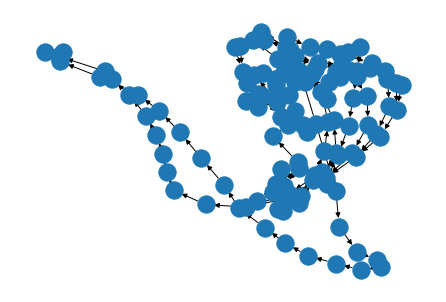

In [332]:
add_counter = 0
master = []

G = nx.DiGraph()
# G = nx.Graph()

pt1 = list(RNA.ptable(s1))
pt2 = list(RNA.ptable(s2))
bp_dist = RNA.bp_distance(s1, s2)
fc = RNA.fold_compound(sequence)


pt = pt1.copy()
sE = last_en = fc.eval_structure_pt(pt)


start_node = last_node = (tuple(pt),0,sE)
G.add_node(last_node)

to_improve = []

paths = []
moves = [(0,0, sE)]
# init fillup

for i in range(bp_dist):
    best_en = np.inf
    best_move = -1
    for pos, (a,b) in enumerate(find_moves(pt, pt2)):    
        next_en = fc.eval_move_pt(pt, a, b) + last_en
        # print (a,b, next_en)
        if next_en < best_en:
            best_en = next_en
            best_move = a, b
    curr_en = fc.eval_move_pt(pt, best_move[0], best_move[1]) + last_en
    pt = adjust_pt(pt, best_move[0], best_move[1])
    if curr_en > sE:
        sE = curr_en
    moves.append((best_move[0], best_move[1], curr_en))
    # print (best_en, best_move, curr_en, sE)

    curr_node = (tuple(pt),i+1,curr_en)    
    # print ("add", curr_node, RNA.db_from_ptable(curr_node[0]),curr_en, sE)

    to_improve.append((curr_node,0,1))

    G.add_node(curr_node)
    G.add_edge(last_node, curr_node)
    G[last_node][curr_node]['label'] = (best_move[0], best_move[1])
    G[last_node][curr_node]['weight'] = [(0, curr_en, sE)]
    last_node = curr_node
    last_en = curr_en


end_node = curr_node
paths.append((moves,0))
moves = []
pt = pt2.copy()
sE = last_en = fc.eval_structure_pt(pt)

for i in range(bp_dist):
    i = bp_dist-i
    best_en = np.inf
    best_move = -1
    for pos, (a,b) in enumerate(find_moves(pt, pt1)):    
        next_en = fc.eval_move_pt(pt, a, b) + last_en
        # print (a,b, next_en)
        if next_en < best_en:
            best_en = next_en
            best_move = a, b
    curr_en = fc.eval_move_pt(pt, best_move[0], best_move[1]) + last_en
    pt = adjust_pt(pt, best_move[0], best_move[1])
    if curr_en > sE:
        sE = curr_en
    moves.insert(0, (-best_move[0], -best_move[1], curr_en))    
    # print (best_en, best_move, curr_en, sE)

    curr_node = (tuple(pt),i-1,curr_en)
    # print ("add", curr_node[1], RNA.db_from_ptable(curr_node[0]),curr_en, sE)

    to_improve.append((curr_node,1,0))
    # if G.has_node(curr_node):
        # print ("ex")
    if G.has_edge(curr_node, last_node):
        G[curr_node][last_node]['weight'].append((1, curr_en, sE))
    else:
        G.add_edge(curr_node, last_node)
        G[curr_node][last_node]['label'] = (-best_move[0], -best_move[1])
        G[curr_node][last_node]['weight'] = [(1, curr_en, sE)]

    # G.add_edge(last_node, curr_node)

    # G[last_node][curr_node]['label'] = (-best_move[0], -best_move[1], 1, sE)

    # G[last_node][curr_node]['weight'] = curr_en, sE# 
    last_node = curr_node
    last_en = curr_en

moves.insert(0,(0,0, sE))
paths.append((moves,1))

path_lookup = dict()
path_lookup[1] = 0
path_lookup[0] = 0

# finish paths first, then "backtrack"
def get_path(pathid, start, end, direction=True):

    # print (start)
    pt, i, _ = start
    pt = list(pt).copy()
    endpt, _, _ = end
    endpt = list(endpt)
    curr_node = start
    if direction:
        moves = [(0,0,fc.eval_structure_pt(pt))]
    else:
        moves = []

    while pt != endpt:
        
        if direction:
            for node1,node2 in G.out_edges(curr_node):
                i,j = G[node1][node2]['label']   
                pids = [i[0] for i in G[node1][node2]['weight']]
                if pathid in pids:
                    break
            pt = adjust_pt(pt, i, j)
            en = fc.eval_structure_pt(pt)
            moves.append((i,j,en))
            curr_node = node2
        
        if not direction:
            for node1,node2 in G.in_edges(curr_node):
                i,j = G[node1][node2]['label']
                pids = [i[0] for i in G[node1][node2]['weight']]
                if pathid in pids:
                    # print ("here")
                    break
            en = fc.eval_structure_pt(pt)
            pt = adjust_pt(pt, -i, -j)
            moves.append((i,j, en))
            curr_node = node1
                        
            # break

    if not direction:
        moves.append((0,0,fc.eval_structure_pt(pt)))
        moves = moves[::-1]

    return moves


def get_sE(path):
    return np.max([i[2] for i in path])


def add_greedy(curr_node, path, direction):    
    # if we find a better sE, the whole path gets a new ID
    # each NODE needs to have sE
    pt, current_bp, en = curr_node
    pt = list(pt).copy()

    # if direction:
    #     print ("fwd path", path)
    # else:
    #     print ("bwd path", path)
    
    # since our path is partial, lets find out the sE so far
    sE = np.max([i[2] for i in path])
    last_en = [i[2] for i in path][0]
    last_en = fc.eval_structure_pt(pt)
    # print (path, sE, last_en, fc.eval_structure_pt(pt))

    if direction:
        endpt = pt1
    else:
        endpt = pt2

    add_path = []

    while pt != endpt:
        best_en = np.inf
        best_move = -1
        if direction:
            for pos, (a,b) in enumerate(find_moves(pt, pt1)):    
                next_en = fc.eval_move_pt(pt, a, b) + last_en
                # print (a,b, next_en)
                if next_en < best_en:
                    best_en = next_en
                    best_move = a, b
            # curr_en = fc.eval_move_pt(pt, best_move[0], best_move[1]) + last_en
            pt = adjust_pt(pt, best_move[0], best_move[1])
            add_path.insert(0, (-best_move[0], -best_move[1], last_en))
            last_en = best_en

        else:
            for pos, (a,b) in enumerate(find_moves(pt, pt2)):    
                next_en = fc.eval_move_pt(pt, a, b) + last_en
                # print (a,b, next_en)
                if next_en < best_en:
                    best_en = next_en
                    best_move = a, b

            curr_en = fc.eval_move_pt(pt, best_move[0], best_move[1]) + last_en
            pt = adjust_pt(pt, best_move[0], best_move[1])
            add_path.append((best_move[0], best_move[1], curr_en))
            # print (RNA.db_from_ptable(pt), best_move, curr_en)
            last_en = curr_en
            # break

    if direction:
        path = [(0,0,fc.eval_structure_pt(pt1))] + add_path+path
    else:
        path += add_path 

    return path


def path_to_graph(path):

    pt1 = list(RNA.ptable(s1))
    pt2 = list(RNA.ptable(s2))
    bp_dist = RNA.bp_distance(s1, s2)
    pt = pt1.copy()
    sE = last_en = fc.eval_structure_pt(pt)
    start_node = last_node = (tuple(pt),0,sE)
    new_pathid = False    

    # print (len(G.edges))

    for e, (i,j,en) in enumerate(path):
        if i==0: continue

        

        curr_en = fc.eval_move_pt(pt, i, j) + last_en
        pt = adjust_pt(pt, i, j)
        if curr_en > sE:
            sE = curr_en

        # print (i,j, last_en, "curr en", curr_en)

        curr_node = (tuple(pt),e,curr_en)

        # if not G.has_node(curr_node):
        #     print ("node does not exist")
            # print (curr_node)
        # else:
            # print ("node exists")
            # print (curr_node)
        # print (curr_node)


        if G.has_edge(last_node, curr_node):

            last_en = curr_en
            last_node = curr_node

            continue
            # G[curr_node][last_node]['weight'].append((1, curr_en, sE))
        else:
            if new_pathid == False:
                new_pathid = len(paths)+1
            # print ("new path", new_pathid, i, j, e)
            # print (curr_node, "->", last_node, i, j)
                
            G.add_edge(last_node, curr_node)
            G[last_node][curr_node]['label'] = (i, j)
            G[last_node][curr_node]['weight'] = [(new_pathid, curr_en, sE)]

            last_en = curr_en
            last_node = curr_node

    return new_pathid


m1 = get_path(0, start_node, end_node, direction=True)
m2 = get_path(1, end_node, start_node, direction=False)
paths = [m1, m2]
sE = np.min([get_sE(m1), get_sE(m2)])


for curr_node, pathid, direction in to_improve:
    pt, current_bp, en = curr_node
    # if current_bp != 5: continue
    # strip path
    if direction:        
        path = paths[pathid][current_bp+1:]
        if path == [] or len(path)==1: continue
        p1 = add_greedy(curr_node, path, direction)
        p1en =  get_sE(p1)
        if p1en <= sE:
            # print (p1en, "add p1")
            sE = np.min([sE, p1en])
            new_pathid = path_to_graph(p1)
            if new_pathid:
                paths.append(p1)
            # break
    else:
        path = paths[pathid][:current_bp+1]
        if path == [] or len(path)==1: continue
        p2 = add_greedy(curr_node, path, direction)
        p2en =  get_sE(p2)
        if p2en <= sE:
            # print (p2en, "add p2")
            sE = np.min([sE, p2en])
            new_pathid = path_to_graph(p2)
            if new_pathid:
                paths.append(p2)
            # break

for p in paths:
    print (get_sE(p))
    # print_moves(sequence, s1, s2, p)

print_moves(sequence, s1, s2, paths[-1])
# print_moves(sequence, s1, s2, paths[0])

# print 
for node1, node2 in G.edges():
    G[node1][node2]['weight'] = 1
    # print (node1, node2)

nx.draw(G)